<a href="https://colab.research.google.com/github/alexandster/anti-Asian-BERT/blob/main/BERT_anti_Asian_fine_tune_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load dataset - labels 0: not hateful, 1: hateful

In [ ]:
import numpy as np
df = pd.read_excel('/content/drive/MyDrive/Research Projects/AAPI2/data/combined_v2.xlsx').sample(frac=1,random_state=0)
df.head()



,ID,Tweet ID,Text,label01,Source
24708,24709,1.304248e+18,"Good read and great reporting, as usual, from ...",0,AL
19760,19761,1.239712e+18,@eugenegu @realdonaldtrump #chinesevirus is tr...,0,Studies
27137,27138,3.133488e+09,So @realDonaldTrump sent tons of our PPE to Ch...,0,DH
2396,2397,1.214193e+18,@coffee_ted They are more like terrorists. #Po...,0,Studies
25904,25905,1.250981e+18,Quarantine got me thinking about being a veget...,0,AY


In [ ]:
#convert label to integer
df = df.astype({"label01": int})
df.dtypes
df.head()

,ID,Tweet ID,Text,label01,Source
24708,24709,1.304248e+18,"Good read and great reporting, as usual, from ...",0,AL
19760,19761,1.239712e+18,@eugenegu @realdonaldtrump #chinesevirus is tr...,0,Studies
27137,27138,3.133488e+09,So @realDonaldTrump sent tons of our PPE to Ch...,0,DH
2396,2397,1.214193e+18,@coffee_ted They are more like terrorists. #Po...,0,Studies
25904,25905,1.250981e+18,Quarantine got me thinking about being a veget...,0,AY


In [ ]:
df.shape

(27290, 5)

In [ ]:
# check class distribution
df['label01'].value_counts(normalize = True)

0    0.806303
1    0.193697
Name: label01, dtype: float64

In [ ]:
#class balancing
# df1 = df[df['label01'] == 1]
# df2 = pd.concat([df, df1, df1, df1])
# df2['label01'].value_counts(normalize = True)

In [ ]:
#split into train and test sets
from sklearn.model_selection import train_test_split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'], df['label01'], 
                                                                    random_state=2018, 
                                                                    test_size=0.05, 
                                                                    stratify=df['label01'])

In [ ]:
#merge text with labels train
train = pd.concat([train_text, train_labels], axis=1)
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train.head()

,DATA_COLUMN,LABEL_COLUMN
17723,"iâ€™ll leave it up to the doctors,scientists,h...",0
2578,Coronavirus Outbreak: Nepal initiates screenin...,0
9429,RT @FredWilliams77 PANDEMIC #SARSCoV2 #covid...,0
17580,amazing videos from italy of italians singing ...,0
20955,"@xhnews it's 'wuhan virus', this shit came out...",0


In [ ]:
#merge text with labels test
test = pd.concat([temp_text, temp_labels], axis=1)
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test.head()

,DATA_COLUMN,LABEL_COLUMN
23919,Helpful advice here. Answers some common quest...,0
26406,Ima tell my child only way you came about was...,0
27080,WHO cares about defending and protecting China...,0
17445,#wuhancoronavius or #kungflu started in: #chi...,1
13982,i had to go and see for myself. sanitizing pro...,0


In [ ]:
#how many train and test samples?
print(train.shape)
print(test.shape)

(25925, 2)
(1365, 2)


# Find class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train['LABEL_COLUMN']), 
    y = train_labels)

print(class_wts)

[0.6201263  2.58114297]


In [ ]:
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 1

In [ ]:
#data structure
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [ ]:
#define function to convert data to examples
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

#define function to convert examples to tensorflow dataset  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
#call functions
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

#fit model
history = model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
1622/1622 [==============================] - 1303s 786ms/step - loss: 0.0294 - accuracy: 0.9900 - val_loss: 0.4338 - val_accuracy: 0.8960
Epoch 2/2
1622/1622 [==============================] - 1274s 785ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.5314 - val_accuracy: 0.8894


# Model diagnostics

In [ ]:
#precision, recall, f1-score
from sklearn.metrics import classification_report
preds=model.predict(validation_data)
preds=np.argmax(preds.logits, axis=1)
print(classification_report(temp_labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1101
           1       0.71      0.72      0.71       264

    accuracy                           0.89      1365
   macro avg       0.82      0.82      0.82      1365
weighted avg       0.89      0.89      0.89      1365



In [ ]:
#confusion matrix
pd.crosstab(temp_labels, preds)

col_0,0,1
label01,,
0,1025,76
1,75,189


In [ ]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(temp_labels, preds)

0.8893772893772893

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


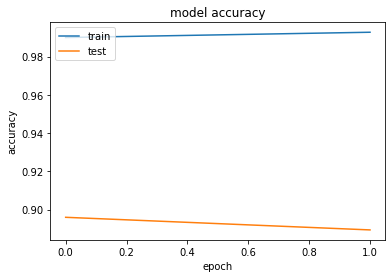

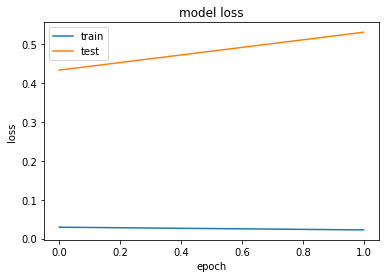

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#save model
# import torch
# model.save_pretrained('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedbertmodel2/')
# tokenizer.save_pretrained('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/')






('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/tokenizer_config.json',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/special_tokens_map.json',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/vocab.txt',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/added_tokens.json')

In [ ]:
#end